# Supplementary Figure for Fig1: Evaluate effect of different subsampling fractions on leiden clustering

Question:
- how many pixels do we need to sample to get a stable clustering result?
- how large is variation due to different leiden seeds and due to different subsampling seeds?

Approach:
- test different orders of magnitude to sample pixels for leiden clustering
- calculate each subset + clustering several times with different seeds
- compare clusterings of different subsets (stability) and clusterings done with different amounts of pixels (correct number of subsampled pixels)
- compare to annotated "groundtruth" clustering

In [9]:
from campa.tl import Cluster
from campa.data import MPPData
import os
import numpy as np
import seaborn as sns
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import scanpy as sc
import anndata as ad
from campa.constants import EXPERIMENT_DIR
from sklearn import metrics

In [2]:
fig_dir = 'fig1_suppl_cluster_subsampling'
os.makedirs(fig_dir, exist_ok=True)

In [3]:
clus = Cluster.from_cluster_data_dir('VAE_all/CondVAE_pert-CC/aggregated/sub-0.001')
clus.set_cluster_name('clustering_res0.5')

In [4]:
print(clus.cluster_mpp.data('latent').shape)
display(clus.config)

(154906, 16)


{'data_config': 'NascentRNA',
 'data_dirs': ['184A1_unperturbed/I09',
  '184A1_unperturbed/I11',
  '184A1_unperturbed/J10',
  '184A1_unperturbed/J12',
  '184A1_DMSO/I14',
  '184A1_DMSO/J16',
  '184A1_AZD4573/I13',
  '184A1_AZD4573/I17',
  '184A1_AZD4573/J14',
  '184A1_AZD4573/J18',
  '184A1_AZD4573/J21',
  '184A1_CX5461/I18',
  '184A1_CX5461/J09',
  '184A1_CX5461/J22',
  '184A1_TSA/I16',
  '184A1_TSA/J13',
  '184A1_TSA/J20',
  '184A1_triptolide/I10',
  '184A1_triptolide/J15',
  '184A1_meayamycin/I12',
  '184A1_meayamycin/I20'],
 'process_like_dataset': '184A1_all_frac0005_neigh3_cond_pert-CC',
 'subsample': True,
 'som_kwargs': {},
 'subsample_kwargs': {'frac': 0.001},
 'subset': False,
 'subset_kwargs': {},
 'seed': 42,
 'cluster_data_dir': 'VAE_all/CondVAE_pert-CC/aggregated/sub-0.001',
 'cluster_name': 'clustering_res0.5',
 'cluster_rep': 'latent',
 'cluster_method': 'leiden',
 'leiden_resolution': 0.8,
 'kmeans_n': 20,
 'umap': True,
 'predict_cluster_imgs': True}

## get different subsets for clustering
- differently sized subsets
- repeat with different seeds for subsampling to get an idea of the variation in the clustering

In [42]:
seeds = [0,1,2,3,4]
nums = [300000,len(clus.cluster_mpp.data('latent')),75000,37000,19000,9300,4600,2300,1100]
nums_per_data_dir = [int(n/len(clus.config['data_dirs'])) for n in nums]

data = {num: [[] for _ in seeds] for num in nums}
for data_dir in clus.config['data_dirs']:
    print(data_dir)
    # load data
    mpp_data = MPPData.from_data_dir(os.path.join('VAE_all/CondVAE_pert-CC/aggregated', 'full_data', data_dir), keys=['latent'], base_dir=EXPERIMENT_DIR)
    # subsample latent
    for num in nums:
        n = int(num/len(clus.config['data_dirs']))
        for i, seed in enumerate(seeds):
            rng = np.random.RandomState(seed=seed)
            selected = rng.choice(len(mpp_data.data('latent')), n, replace=False)
            data[num][i].append(mpp_data.data('latent')[selected])
    

184A1_unperturbed/I09
184A1_unperturbed/I11
184A1_unperturbed/J10
184A1_unperturbed/J12
184A1_DMSO/I14
184A1_DMSO/J16
184A1_AZD4573/I13
184A1_AZD4573/I17
184A1_AZD4573/J14
184A1_AZD4573/J18
184A1_AZD4573/J21
184A1_CX5461/I18
184A1_CX5461/J09
184A1_CX5461/J22
184A1_TSA/I16
184A1_TSA/J13
184A1_TSA/J20
184A1_triptolide/I10
184A1_triptolide/J15
184A1_meayamycin/I12
184A1_meayamycin/I20


In [46]:
# save data
pickle.dump(data, open(os.path.join(fig_dir, 'subsampled_data.pickle'), 'wb'))

## cluster and project result to reference subsample

In [4]:
data = pickle.load(open(os.path.join(fig_dir, 'subsampled_data.pickle'), 'rb'))

# join all data_dirs
seeds = [0,1,2,3,4]
nums = [300000,len(clus.cluster_mpp.data('latent')),75000,37000,19000,9300,4600,2300,1100]
for num in nums:
    for i in range(len(seeds)):
        data[num][i] = np.concatenate(data[num][i])

In [5]:
from pynndescent import NNDescent
def project_clustering(samples, from_samples, from_clusters):
    index = NNDescent(from_samples)
    # func for getting max count cluster in each row
    def most_frequent(arr):
        els, counts = np.unique(arr, return_counts=True)
        return els[np.argmax(counts)]
    # project clusters
    neighs = index.query(samples, k=15)[0]
    projected_clusters = np.apply_along_axis(most_frequent, arr=np.array(from_clusters)[neighs], axis=1)
    return projected_clusters

In [11]:
resolution = 0.5
# when varying sub_seed, fix leiden_seeds to 0; do not need all combinations
#leiden_seeds = [0] 
leiden_seeds = [1, 2, 3, 4]
#sub_seeds = [0,1,2,3,4] 
sub_seeds = [0]

if os.path.exists(os.path.join(fig_dir, 'cluster_subsamples_on_reference.csv')):
    df = pd.read_csv(os.path.join(fig_dir, 'cluster_subsamples_on_reference.csv'), index_col=0)
else:
    df = None
    
for num in nums:
    for sub_seed in sub_seeds:
        if num in [300000,len(clus.cluster_mpp.data('latent')),75000,37000,19000]:
            continue
        print(num)
        adata = ad.AnnData(data[num][sub_seed])
        sc.pp.neighbors(adata)
        for seed in leiden_seeds:
            print(num, seed, sub_seed)
            sc.tl.leiden(adata, resolution=resolution, key_added='clustering', random_state=seed)
            cl = adata.obs['clustering']
            # project to reference
            proj_cl = project_clustering(clus.cluster_mpp.data('latent'), from_samples=adata.X, from_clusters=cl)
            if df is None:
                df = pd.DataFrame(proj_cl, columns=[f'cl_{num}_{seed}_sub{sub_seed}'])
            else:
                df[f'cl_{num}_{seed}_sub{sub_seed}'] = proj_cl
            df.to_csv(os.path.join(fig_dir, 'cluster_subsamples_on_reference.csv'))
 

9300
9300 1 0
9300 2 0
9300 3 0
9300 4 0
4600
4600 1 0
4600 2 0
4600 3 0
4600 4 0
2300
2300 1 0
2300 2 0
2300 3 0
2300 4 0
1100
1100 1 0
1100 2 0
1100 3 0
1100 4 0


## compare cluster overlap with reference clustering
as leiden clustering itself varies a lot wrt different random seeds, we have to compare the subsampling variation with the expected random leiden variation (from the same subset)
- to judge how stable a clustering is, calculate cluster overlap scores between all pairs and take mean of resulting scores
- then compare these score distributions of the leiden seed variation to the subsampling variation

plot ideas
1. compute mean + ci of overlap within one size (num). Compare variation due to leiden with variation due to sampling. Plot line plot of 2 kinds of variation + ci 095 against num
2. which clusters are mostly varying at chosen num. compare overlap scores for each cluster (again for sampling + leiden variation) and plot per cluster. calculate homogeneity per label as a score for this (high homogeneity if clusers are either label 1 or label 0) 

In [5]:
df = pd.read_csv(os.path.join(fig_dir, 'cluster_subsamples_on_reference.csv'), index_col=0)

In [13]:
# calculate scores between clustering and reference cluster
cl_list = [c for c in df.columns if 'cl_' in c]
print(cl_list)

res_varsub = {
    'rand_score': [],
    'mi_score': [],
    'num': [],
    'c1': [],
    'c2': []
}
for i in range(len(cl_list)):
    c1 = cl_list[i]
    num, leiden_seed, sub_seed = c1.split('_')[1:]
    print(num, leiden_seed, sub_seed)
    if leiden_seed != '0':
        continue
    for j in range(i,len(cl_list)):
        c2 = cl_list[j]
        num2, leiden_seed2, sub_seed2 = c2.split('_')[1:]
        if leiden_seed2 != '0':
            continue
        if num != num2:
            continue
        res_varsub['num'].append(num)
        res_varsub['c1'].append(c1)
        res_varsub['c2'].append(c2)
        res_varsub['rand_score'].append(metrics.adjusted_rand_score(df[c1], df[c2]))
        res_varsub['mi_score'].append(metrics.adjusted_mutual_info_score(df[c1], df[c2]))

res_varleiden = {
    'rand_score': [],
    'mi_score': [],
    'num': [],
    'c1': [],
    'c2': []
}
for i in range(len(cl_list)):
    c1 = cl_list[i]
    num, leiden_seed, sub_seed = c1.split('_')[1:]
    print(num,leiden_seed,sub_seed)
    if sub_seed != 'sub0':
        continue
    for j in range(i,len(cl_list)):
        c2 = cl_list[j]
        num2, leiden_seed2, sub_seed2 = c2.split('_')[1:]
        if sub_seed2 != 'sub0':
            continue
        if num != num2:
            continue
        if leiden_seed not in ['0','1']:
            continue
        res_varleiden['num'].append(num)
        res_varleiden['c1'].append(c1)
        res_varleiden['c2'].append(c2)
        res_varleiden['rand_score'].append(metrics.adjusted_rand_score(df[c1], df[c2]))
        res_varleiden['mi_score'].append(metrics.adjusted_mutual_info_score(df[c1], df[c2]))

['cl_9300_0_sub0', 'cl_9300_0_sub1', 'cl_9300_0_sub2', 'cl_9300_0_sub3', 'cl_9300_0_sub4', 'cl_4600_0_sub0', 'cl_4600_0_sub1', 'cl_4600_0_sub2', 'cl_4600_0_sub3', 'cl_4600_0_sub4', 'cl_2300_0_sub0', 'cl_2300_0_sub1', 'cl_2300_0_sub2', 'cl_2300_0_sub3', 'cl_2300_0_sub4', 'cl_1100_0_sub0', 'cl_1100_0_sub1', 'cl_1100_0_sub2', 'cl_1100_0_sub3', 'cl_1100_0_sub4', 'cl_300000_0_sub0', 'cl_300000_0_sub1', 'cl_300000_0_sub2', 'cl_300000_0_sub3', 'cl_300000_0_sub4', 'cl_154906_0_sub0', 'cl_154906_0_sub1', 'cl_154906_0_sub2', 'cl_154906_0_sub3', 'cl_154906_0_sub4', 'cl_75000_0_sub0', 'cl_75000_0_sub1', 'cl_75000_0_sub2', 'cl_75000_0_sub3', 'cl_75000_0_sub4', 'cl_37000_0_sub0', 'cl_37000_0_sub1', 'cl_37000_0_sub2', 'cl_37000_0_sub3', 'cl_37000_0_sub4', 'cl_19000_0_sub0', 'cl_19000_0_sub1', 'cl_19000_0_sub2', 'cl_19000_0_sub3', 'cl_19000_0_sub4', 'cl_300000_1_sub0', 'cl_300000_2_sub0', 'cl_300000_3_sub0', 'cl_300000_4_sub0', 'cl_154906_1_sub0', 'cl_154906_2_sub0', 'cl_154906_3_sub0', 'cl_154906_4_s

### plot comparison of leiden cluster and random subsampling variation for different number of samples

In [14]:
df_varleiden = pd.DataFrame(res_varleiden)
df_varleiden['num'] = df_varleiden['num'].astype(int)
df_varsub = pd.DataFrame(res_varsub)
df_varsub['num'] = df_varsub['num'].astype(int)
df_varsub = df_varsub[~(df_varsub.c1.str.endswith('subsub1') | df_varsub.c2.str.endswith('subsub1'))]

df_varleiden.to_csv(os.path.join(fig_dir, 'leiden_subsampling_varleiden.csv'))
df_varsub.to_csv(os.path.join(fig_dir, 'leiden_subsampling_varsub.csv'))

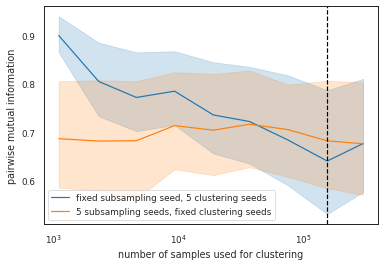

In [15]:
sns.set_style('white')
sns.set_context('paper')

sns.lineplot(data=df_varleiden, x='num', y='mi_score', ci=95, label='fixed subsampling seed, 5 clustering seeds')
g = sns.lineplot(data=df_varsub, x='num', y='mi_score', ci=95, label='5 subsampling seeds, fixed clustering seeds')
g.set(xscale="log")
g.axvline(len(clus.cluster_mpp.data('latent')), c='black', ls='--')
g.set_xlabel('number of samples used for clustering')
g.set_ylabel('pairwise mutual information')
plt.savefig(os.path.join(fig_dir, 'cluster_subsampling_mutual_information.png'), dpi=300, bbox_inches='tight')

### comparison of variation for chosen number of samples

In [15]:
clustering = clus.cluster_mpp.data('clustering_res0.5')
clusters = np.unique(clustering)
cl_list = [c for c in df.columns if 'cl_' in c]

comp_varsub = {
    'homogeneity_score': [],
    'num': [],
    'cl': []
}

comp_varleiden = {
    'homogeneity_score': [],
    'num': [],
    'cl': []
}

for i in range(len(cl_list)):
    c1 = cl_list[i]
    num, leiden_seed, sub_seed = c1.split('_')[1:]
    if num != str(len(clus.cluster_mpp.data('latent'))):
        continue
    if leiden_seed != '0':
        continue
    if sub_seed == 'subsub1':
        continue
    for cl in clusters:
        print(num, leiden_seed, sub_seed, cl)
        comp_varsub['homogeneity_score'].append(metrics.homogeneity_score(clustering==cl, df[c1]))
        comp_varsub['num'].append(num)
        comp_varsub['cl'].append(cl)
        
for i in range(len(cl_list)):
    c1 = cl_list[i]
    num, leiden_seed, sub_seed = c1.split('_')[1:]
    if num != str(len(clus.cluster_mpp.data('latent'))):
        continue
    if sub_seed != 'sub0':
        continue
    for cl in clusters:
        print(num, leiden_seed, sub_seed, cl)
        comp_varleiden['homogeneity_score'].append(metrics.homogeneity_score(clustering==cl, df[c1]))
        comp_varleiden['num'].append(num)
        comp_varleiden['cl'].append(cl)
        
df_varsub = pd.DataFrame(comp_varsub)
df_varsub['type'] = 'varying subsampling seeds'

df_varleiden = pd.DataFrame(comp_varleiden)
df_varleiden['type'] = 'varying leiden seeds'

154906 0 sub0 0
154906 0 sub0 1
154906 0 sub0 2
154906 0 sub0 3
154906 0 sub0 4
154906 0 sub0 5
154906 0 sub0 6
154906 0 sub0 7
154906 0 sub0 8
154906 0 sub0 9
154906 0 sub1 0
154906 0 sub1 1
154906 0 sub1 2
154906 0 sub1 3
154906 0 sub1 4
154906 0 sub1 5
154906 0 sub1 6
154906 0 sub1 7
154906 0 sub1 8
154906 0 sub1 9
154906 0 sub2 0
154906 0 sub2 1
154906 0 sub2 2
154906 0 sub2 3
154906 0 sub2 4
154906 0 sub2 5
154906 0 sub2 6
154906 0 sub2 7
154906 0 sub2 8
154906 0 sub2 9
154906 0 sub3 0
154906 0 sub3 1
154906 0 sub3 2
154906 0 sub3 3
154906 0 sub3 4
154906 0 sub3 5
154906 0 sub3 6
154906 0 sub3 7
154906 0 sub3 8
154906 0 sub3 9
154906 0 sub4 0
154906 0 sub4 1
154906 0 sub4 2
154906 0 sub4 3
154906 0 sub4 4
154906 0 sub4 5
154906 0 sub4 6
154906 0 sub4 7
154906 0 sub4 8
154906 0 sub4 9
154906 0 sub0 0
154906 0 sub0 1
154906 0 sub0 2
154906 0 sub0 3
154906 0 sub0 4
154906 0 sub0 5
154906 0 sub0 6
154906 0 sub0 7
154906 0 sub0 8
154906 0 sub0 9
154906 1 sub0 0
154906 1 sub0 1
154906 1

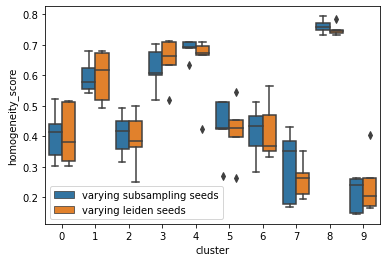

In [16]:
g = sns.boxplot(data=pd.concat([df_varleiden, df_varsub]), x='cl', y='homogeneity_score', hue='type')
g.set(xlabel='cluster')
g.legend_.set_title(None)

In [17]:
# do the same for annotated clustering
def annotate_clustering(clustering, annotation, cluster_name, annotation_col=None):
    if annotation_col is None:
        return clustering
    if cluster_name == annotation_col:
        return clustering
    return np.array(annotation.set_index(cluster_name)[annotation_col].loc[clustering])

clustering = annotate_clustering(clustering, clus.cluster_annotation, 'clustering_res0.5', annotation_col='annotation')
clusters = np.unique(clustering)

In [19]:
comp_varsub = {
    'homogeneity_score': [],
    'num': [],
    'cl': []
}

comp_varleiden = {
    'homogeneity_score': [],
    'num': [],
    'cl': []
}

for i in range(len(cl_list)):
    c1 = cl_list[i]
    num, leiden_seed, sub_seed = c1.split('_')[1:]
    if num != str(len(clus.cluster_mpp.data('latent'))):
        continue
    if leiden_seed != '0':
        continue
    if sub_seed == 'subsub1':
        continue
    for cl in clusters:
        print(num, leiden_seed, sub_seed, cl)
        comp_varsub['homogeneity_score'].append(metrics.homogeneity_score(clustering==cl, df[c1]))
        comp_varsub['num'].append(num)
        comp_varsub['cl'].append(cl)
        
for i in range(len(cl_list)):
    c1 = cl_list[i]
    num, leiden_seed, sub_seed = c1.split('_')[1:]
    if num != str(len(clus.cluster_mpp.data('latent'))):
        continue
    if sub_seed != 'sub0':
        continue
    for cl in clusters:
        print(num, leiden_seed, sub_seed, cl)
        comp_varleiden['homogeneity_score'].append(metrics.homogeneity_score(clustering==cl, df[c1]))
        comp_varleiden['num'].append(num)
        comp_varleiden['cl'].append(cl)
        
df_varsub = pd.DataFrame(comp_varsub)
df_varsub['type'] = 'varying subsampling seeds'

df_varleiden = pd.DataFrame(comp_varleiden)
df_varleiden['type'] = 'varying leiden seeds'

154906 0 sub0 Cajal bodies
154906 0 sub0 Extra-nuclear
154906 0 sub0 Nuclear periphery
154906 0 sub0 Nuclear speckles
154906 0 sub0 Nucleolus
154906 0 sub0 Nucleoplasm
154906 0 sub0 PML bodies
154906 0 sub1 Cajal bodies
154906 0 sub1 Extra-nuclear
154906 0 sub1 Nuclear periphery
154906 0 sub1 Nuclear speckles
154906 0 sub1 Nucleolus
154906 0 sub1 Nucleoplasm
154906 0 sub1 PML bodies
154906 0 sub2 Cajal bodies
154906 0 sub2 Extra-nuclear
154906 0 sub2 Nuclear periphery
154906 0 sub2 Nuclear speckles
154906 0 sub2 Nucleolus
154906 0 sub2 Nucleoplasm
154906 0 sub2 PML bodies
154906 0 sub3 Cajal bodies
154906 0 sub3 Extra-nuclear
154906 0 sub3 Nuclear periphery
154906 0 sub3 Nuclear speckles
154906 0 sub3 Nucleolus
154906 0 sub3 Nucleoplasm
154906 0 sub3 PML bodies
154906 0 sub4 Cajal bodies
154906 0 sub4 Extra-nuclear
154906 0 sub4 Nuclear periphery
154906 0 sub4 Nuclear speckles
154906 0 sub4 Nucleolus
154906 0 sub4 Nucleoplasm
154906 0 sub4 PML bodies
154906 0 sub0 Cajal bodies
154906 0

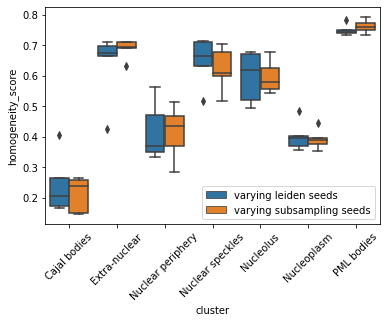

In [25]:
g = sns.boxplot(data=pd.concat([df_varleiden, df_varsub]), x='cl', y='homogeneity_score', hue='type')
g.set(xlabel='cluster')
g.legend_.set_title(None)
g.set_xticklabels(g.get_xticklabels(), 
                          rotation=45, 
                          horizontalalignment='center')

plt.savefig(os.path.join(fig_dir, 'homogeneity_score.png'), dpi=300, bbox_inches='tight')